In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
pd.set_option("max_colwidth", 100)

In [5]:
sns.set_style('darkgrid')

In [6]:
def top_N_vals(vals:list,n=-1,filter_vals=True,return_dict=False):
    
    if filter_vals:
        # filter bert specific terms out
        vals = [val for val in vals if val['word'] not in ('[CLS]','[SEP]')]
        
    sort_vals = sorted(vals,key=lambda x:x['score'],reverse=True)
    
    if n >0:
        sort_vals=sort_vals[0:n]
    
    words = [word['word'] for word in sort_vals]
    
    if return_dict:
        return words, sort_vals
    
    return words

def top_sentiment_words(vals:list,n=-1,filter_vals=True):
    """select only those in the right direction"""
    
    
    if filter_vals:
        vals = [val for val in vals if val['word'] not in ('[CLS]','[SEP]')]
        
    sort_vals = sorted(vals,key=lambda x:x['score'],reverse=True)
    
    if n >0:
        sort_vals=sort_vals[0:n]
        
    words = [word['word'] for word in sort_vals if word['score']>0]
        
    return words
    
    

In [7]:
def matched_words_score_comparison(row):
    
    score_count=0
    human_list = row['human_words']
    score_len = len(human_list)
    
    vals = row['model_dict']
    vals = [val for val in vals if val['word'] not in ('[CLS]','[SEP]')]
    
    sort_vals = sorted(vals,key=lambda x:x['score'],reverse=True)[0:score_len]
    
    model_list=[word['word'] for word in sort_vals]
    
    
    if score_len > 0:
        for w in human_list:
            if w in model_list:
                score_count+=1

        return score_count / score_len
    else:
        return np.nan

In [8]:
# tided up human words
cleaned_human_words = pd.read_pickle('cleaned_words.pkl')[['label_text','feature_text','human_words']]
cleaned_human_words.head(3)

,label_text,feature_text,human_words
0,{stunned},RT @Jwhitbrook: With the new Picard up on Amazon I can finally get a clean screenshot and ask......,[stunned]
1,{love},"RT @klaushismydaddy: netflix: i love ALL of my programs equally!!! stranger things, lucifer, tig...",[love]
2,{excellent},Just finished Picard on Amazon Prime. Was not expecting to cry. What an excellent show.,[excellent]


In [9]:
# raw bert model scores
bert_results = pd.read_pickle('all_scores_bert_25steps.pkl')[['model_dict','sentiment']]

bert_results = pd.concat((bert_results,cleaned_human_words),axis=1)

# extract the top bert words
bert_results['bert_model_words'] = bert_results.model_dict.apply(top_sentiment_words)
bert_results['bert_five_words'] = bert_results.model_dict.apply(top_N_vals, n=5)
bert_results['bert_one_word'] = bert_results.model_dict.apply(top_N_vals, n=1)

bert_results['bert_match_words'] = bert_results.apply(matched_words_score_comparison, axis=1)

bert_results.head(3)

,model_dict,sentiment,label_text,feature_text,human_words,bert_model_words,bert_five_words,bert_one_word,bert_match_words
0,"[{'position': 0, 'score': 0.15727868574772647, 'word': '[CLS]'}, {'position': 1, 'score': 0.1249...",pos,{stunned},RT @Jwhitbrook: With the new Picard up on Amazon I can finally get a clean screenshot and ask......,[stunned],"[a, finally, ask, anyone, can, rt, …, i, with, the, get, @, ., else, j, ##brook, momentarily, :,...","[a, finally, ask, anyone, can]",[a],0.0
1,"[{'position': 0, 'score': 0.21714102995484544, 'word': '[CLS]'}, {'position': 1, 'score': 0.0128...",pos,{love},"RT @klaushismydaddy: netflix: i love ALL of my programs equally!!! stranger things, lucifer, tig...",[love],"[love, i, :, all, equally, of, my, ,, …, :, lucifer, !, ,, netflix, looks, programs, and, rt, ##...","[love, i, :, all, equally]",[love],1.0
2,"[{'position': 0, 'score': 0.1665978808950008, 'word': '[CLS]'}, {'position': 1, 'score': -0.0337...",pos,{excellent},Just finished Picard on Amazon Prime. Was not expecting to cry. What an excellent show.,[excellent],"[excellent, ., cry, show, to, an, on]","[excellent, ., cry, show, to]",[excellent],1.0


In [10]:
# lstm model scores via captum 
lstm_results  = pd.read_pickle('lstm_cap_scores.pkl')[['model_dict']]

lstm_results = pd.concat((lstm_results,cleaned_human_words),axis=1)

# extract the top lstm words
lstm_results['lstm_model_words'] = lstm_results.model_dict.apply(top_sentiment_words)
lstm_results['lstm_five_words'] = lstm_results.model_dict.apply(top_N_vals,n=5)
lstm_results['lstm_one_word'] = lstm_results.model_dict.apply(top_N_vals, n=1)

lstm_results['lstm_match_words'] = lstm_results.apply(matched_words_score_comparison, axis=1)

lstm_results.head(3)

,model_dict,label_text,feature_text,human_words,lstm_model_words,lstm_five_words,lstm_one_word,lstm_match_words
0,"[{'position': 0, 'score': 0.0, 'word': 'xxbos'}, {'position': 1, 'score': 0.021161681041121483, ...",{stunned},RT @Jwhitbrook: With the new Picard up on Amazon I can finally get a clean screenshot and ask......,[stunned],"[i, stunned, ju, …, a, get, picard, finally, amazon, with, clean, momentarily, else, on, up, was...","[i, stunned, ju, …, a]",[i],0.0
1,"[{'position': 0, 'score': 0.0, 'word': 'xxbos'}, {'position': 1, 'score': 0.02491801790893078, '...",{love},"RT @klaushismydaddy: netflix: i love ALL of my programs equally!!! stranger things, lucifer, tig...",[love],"[i, …, !, love, equally, programs, !, of, !, ,, smudged, and, h, ,, looks, netflix, xxup, *, at,...","[i, …, !, love, equally]",[i],0.0
2,"[{'position': 0, 'score': 0.0, 'word': 'xxbos'}, {'position': 2, 'score': -0.1196400374174118, '...",{excellent},Just finished Picard on Amazon Prime. Was not expecting to cry. What an excellent show.,[excellent],"[an, excellent, what, on, ., show, cry, to, finished, not, amazon, ., picard, prime]","[an, excellent, what, on, .]",[an],0.0


In [11]:
combo = pd.concat((bert_results[['sentiment','bert_model_words','bert_one_word', 'bert_five_words','bert_match_words']],
                   lstm_results[['lstm_model_words','lstm_one_word','lstm_five_words','lstm_match_words']],
                   cleaned_human_words),axis=1)
combo.head(3)

,sentiment,bert_model_words,bert_one_word,bert_five_words,bert_match_words,lstm_model_words,lstm_one_word,lstm_five_words,lstm_match_words,label_text,feature_text,human_words
0,pos,"[a, finally, ask, anyone, can, rt, …, i, with, the, get, @, ., else, j, ##brook, momentarily, :,...",[a],"[a, finally, ask, anyone, can]",0.0,"[i, stunned, ju, …, a, get, picard, finally, amazon, with, clean, momentarily, else, on, up, was...",[i],"[i, stunned, ju, …, a]",0.0,{stunned},RT @Jwhitbrook: With the new Picard up on Amazon I can finally get a clean screenshot and ask......,[stunned]
1,pos,"[love, i, :, all, equally, of, my, ,, …, :, lucifer, !, ,, netflix, looks, programs, and, rt, ##...",[love],"[love, i, :, all, equally]",1.0,"[i, …, !, love, equally, programs, !, of, !, ,, smudged, and, h, ,, looks, netflix, xxup, *, at,...",[i],"[i, …, !, love, equally]",0.0,{love},"RT @klaushismydaddy: netflix: i love ALL of my programs equally!!! stranger things, lucifer, tig...",[love]
2,pos,"[excellent, ., cry, show, to, an, on]",[excellent],"[excellent, ., cry, show, to]",1.0,"[an, excellent, what, on, ., show, cry, to, finished, not, amazon, ., picard, prime]",[an],"[an, excellent, what, on, .]",0.0,{excellent},Just finished Picard on Amazon Prime. Was not expecting to cry. What an excellent show.,[excellent]


In [12]:
#cleaned count
combo['count_cleaned'] = combo.human_words.apply(lambda x: len(x))

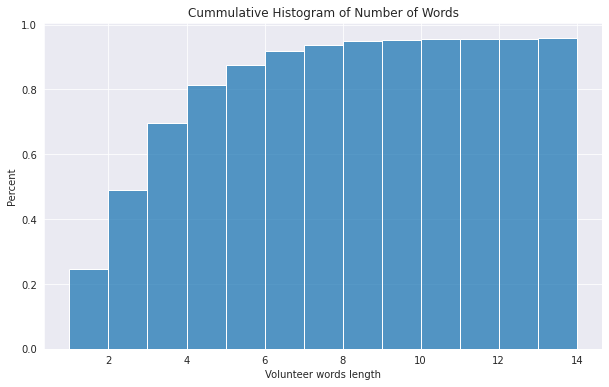

In [14]:
fig,ax = plt.subplots(figsize=(10,6))
weights = np.ones_like(combo.index) / len(combo.index)
sns.histplot(data=combo, x='count_cleaned', bins=[x for x in range(1,15)], cumulative=True, weights=weights,ax=ax )

ax.set(xlabel='Volunteer words length', ylabel='Percent',title='Cummulative Histogram of Number of Words')
fig.savefig('article/word_hist',bbox_inches='tight')

In [16]:
combo.shape

(428, 13)

In [17]:
combo.loc[combo.human_words.map(len)==0].shape

(18, 13)

In [18]:
# remove empty entries
combo = combo.loc[combo.human_words.map(len)>0]
combo.shape

(410, 13)

In [19]:
def reverse_simple_score_comparison(row, model_name):
    
    human_list = row['human_words']
    model_list=row[model_name]
    
    score_count=0
    score_len = len(human_list)
    model_len = len(model_list)
    
    if score_len > 0:
        for w in human_list:
            if w in model_list:
                score_count+=1

        return max(score_count / score_len, score_count / model_len)

    else:
        return np.nan
    


In [20]:
def one_word_score(row, model_name):
    
    human_list = row['human_words']
    model_list=row[model_name]
    
    if model_list[0] in human_list:
        return 1
    
    return 0
    

In [21]:
combo['bert_1_score']= combo.apply(one_word_score,model_name='bert_one_word',axis=1)
combo['lstm_1_score']= combo.apply(one_word_score,model_name='lstm_one_word',axis=1)

In [22]:
combo['rev_bert_5_score']= combo.apply(reverse_simple_score_comparison,model_name='bert_five_words',axis=1)
combo['rev_lstm_5_score']= combo.apply(reverse_simple_score_comparison,model_name='lstm_five_words',axis=1)

In [23]:
combo.loc[combo.count_cleaned>5][['rev_bert_5_score','bert_five_words','human_words']].head(20)


,rev_bert_5_score,bert_five_words,human_words
4,0.2,"[works, ways, both, ##v, @]","[https, t, co, l, hiknq, v, works]"
19,0.8,"[impressed, highly, recommend, it, really]","[good, highly, recommend, really, impressed, love, best, part]"
27,0.2,"[in, aus, i, i, my]","[my, favorite, you’ll, really, like, liked]"
50,0.6,"[must, a, watch, is, you]","[yes, must, watch, make, you, wonder]"
56,0.6,"[good, all, enjoying, pretty, the]","[really, enjoying, it, is, incredible, pretty, good]"
101,0.4,"[highly, recommended, and, i, the]","[emotional, highly, recommended, https, t, co, upv, ivhvfp]"
113,0.6,"[best, the, ##rd, now, one]","[by, far, one, of, the, best]"
114,0.4,"[happy, !, ##oi, the, i]","[makes, me, so, happy, i, can’t, wait]"
118,0.6,"[great, show, a, !, it]","[a, great, show, treat, slightly, brilliant]"
147,0.6,"[excellent, ., ##ana, on, bbc]","[excellent, should, be, on, bbc, question, time]"


In [24]:
combo.loc[combo.count_cleaned<5][['rev_bert_5_score','bert_five_words','human_words']].head(20)


,rev_bert_5_score,bert_five_words,human_words
0,0.000000,"[a, finally, ask, anyone, can]",[stunned]
1,1.000000,"[love, i, :, all, equally]",[love]
2,1.000000,"[excellent, ., cry, show, to]",[excellent]
5,0.000000,"[https, episodes, all, of, :]",[available]
6,1.000000,"[happy, so, favourite, !, amazing]","[favourite, happy]"
7,1.000000,"[excellent, :, the, today, ,]",[excellent]
8,1.000000,"[favorite, ., another, via, great]","[great, favorite]"
9,1.000000,"[must, a, watch, is, you]","[must, watch]"
10,0.500000,"[amazing, an, the, nation, itv]","[amazing, idea]"
11,0.000000,"[a, finally, ask, anyone, can]",[stunned]


In [25]:
combo.bert_1_score.sum()/410, combo.lstm_1_score.sum()/410

(0.4317073170731707, 0.2951219512195122)

In [27]:
def hist_data(dt,lstm_model, bert_model):
    
    weights = np.ones_like(dt.index) / len(dt.index)

    lstm_heights, lstm_bins = np.histogram(dt[lstm_model], weights=weights)
    bert_heights, bert_bins = np.histogram(dt[bert_model], bins=lstm_bins, weights=weights)
    
    return lstm_heights, lstm_bins,bert_heights, bert_bins

In [91]:
def plot_func_split(dt, lstm_model, bert_model, fname=None):

    fig, ax = plt.subplots(2,1, sharex=True,figsize=(12,12))
    
    pos = dt.loc[dt.sentiment=='pos']
    neg = dt.loc[dt.sentiment=='neg']
    
    # positive sentiment

    lstm_heights, lstm_bins,bert_heights, bert_bins = hist_data(pos,lstm_model, bert_model)

    width = (lstm_bins[1] - lstm_bins[0])/2

    ax[0].bar(lstm_bins[:-1], lstm_heights, width=width, facecolor='cornflowerblue', label='LSTM')
    ax[0].bar(bert_bins[:-1]+width, bert_heights, width=width, facecolor='seagreen', label='Transformer')
    ax[0].set_title('Pos')
    ax[0].grid(True)
    
    # negative sentiment
    
    lstm_heights, lstm_bins,bert_heights, bert_bins = hist_data(neg,lstm_model, bert_model)

    width = (lstm_bins[1] - lstm_bins[0])/2
    

    ax[1].bar(lstm_bins[:-1], lstm_heights, width=width,facecolor='cornflowerblue',label='LSTM')
    ax[1].bar(bert_bins[:-1]+width, bert_heights, width=width, facecolor='seagreen', label='Transformer')
    ax[1].set_title('Neg')
    ax[1].grid(True)
    
    # chart tidy
    
    fig.text(0.5, 0.09, 'Score', ha='center')
    fig.text(0.04, 0.5, 'Percent', va='center', rotation='vertical')

    
    plt.legend()
    plt.show()
    
    if fname is not None:
        fig.savefig(f'article/{fname}',bbox_inches='tight')
    

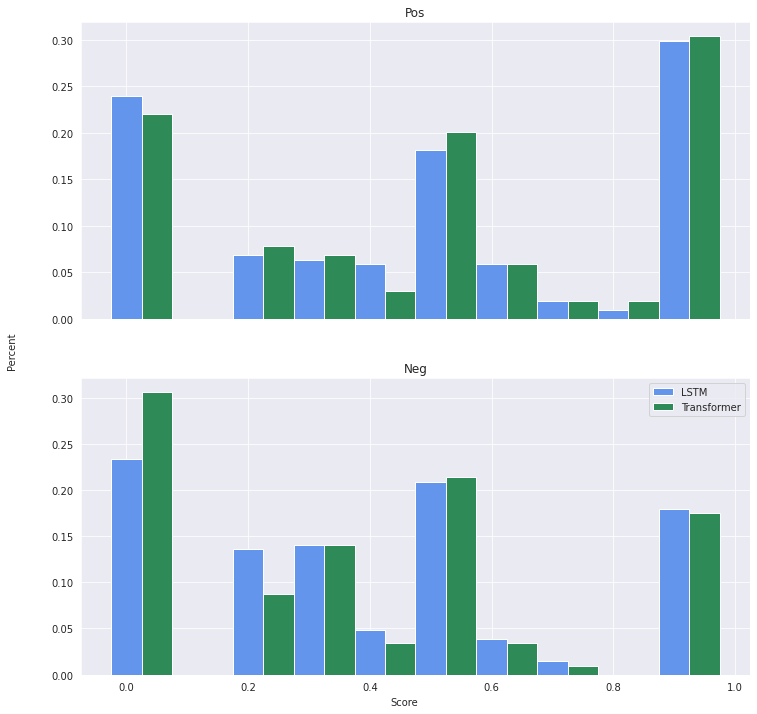

In [92]:
plot_func_split(combo,'rev_lstm_5_score','rev_bert_5_score' ,'overall')

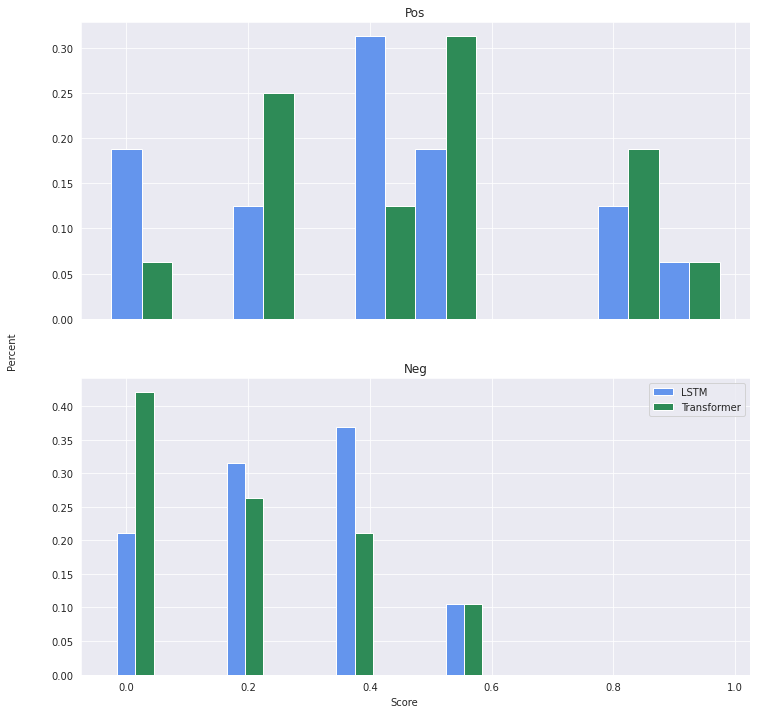

In [93]:
plot_func_split(combo.loc[combo.count_cleaned > 5],'rev_lstm_5_score','rev_bert_5_score' ,'long_human')

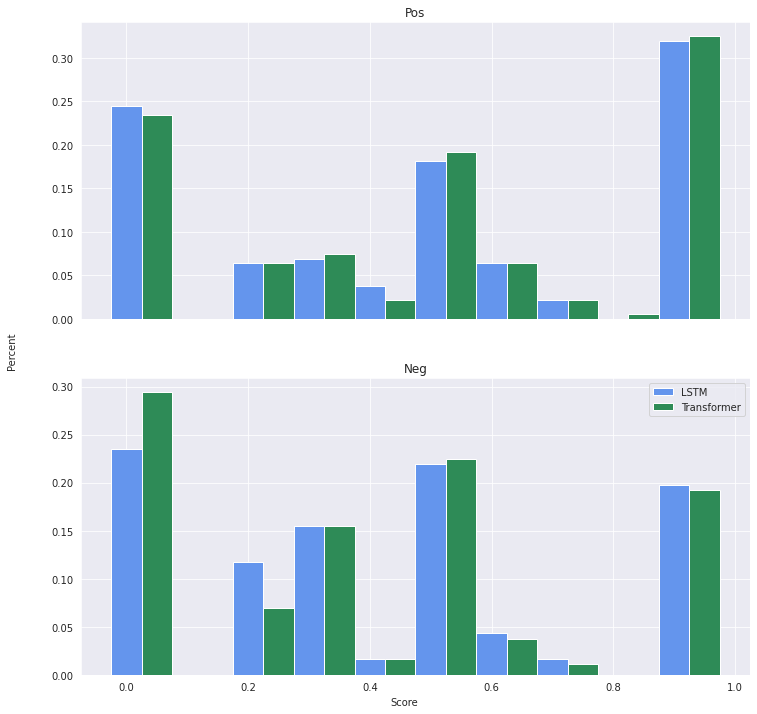

In [94]:
plot_func_split(combo.loc[combo.count_cleaned <=5],'rev_lstm_5_score','rev_bert_5_score' ,'short_human')